# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import umap
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import os
from transformers import AutoTokenizer, AutoModel
import torch
from pathlib import Path

# Configuration des chemins
CHECKPOINT_DIR = Path("checkpoints")
MODELS_DIR = CHECKPOINT_DIR / "models"
EMBEDDINGS_DIR = CHECKPOINT_DIR / "embeddings"

os.makedirs(CHECKPOINT_DIR / "data", exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

DATA_PATH = CHECKPOINT_DIR / "data" / "data_cleaned.parquet"
TITLES_EN_PATH = CHECKPOINT_DIR / "data" / "titles_en.csv"
# Fichiers d'embeddings

EMBEDDINGS_SBERT_PATH = EMBEDDINGS_DIR / "embeddings_sbert.npy"
CNN_MODEL_PATH = MODELS_DIR / "cnn_model.keras"
CNN_EMBEDDINGS_PATH = EMBEDDINGS_DIR / "cnn_embeddings.npy"

2025-12-11 19:52:13.240484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 19:52:13.240693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 19:52:13.266479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 19:52:13.912582: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

## Partie 3 : Analyse et comparaison des embeddings textuels

In [2]:
# Chargement des données
data = pd.read_parquet(DATA_PATH)

### 1. Traduction des descriptions

In [3]:
API_KEY = "0f6b7853-5567-4c01-a117-98b90787e917:fx"
DEEPL_URL = "https://api-free.deepl.com/v2/translate"

# Fonction de traduction avec DeepL
def deepl_translate(text):
    payload = {
        "auth_key": API_KEY,
        "text": text,
        "source_lang": "DE",
        "target_lang": "EN"
    }
    response = requests.post(DEEPL_URL, data=payload)
    return response.json()["translations"][0]["text"]


# Traduction des titres en anglais si le fichier n'existe pas déjà ou si taille incohérente
need_translate = False

if not TITLES_EN_PATH.exists():
    need_translate = True
else:
    titles_csv = pd.read_csv(TITLES_EN_PATH)
    if len(titles_csv) != len(data):
        print(f"⚠️ Fichier titles_en.csv ({len(titles_csv)} lignes) ne correspond pas aux données ({len(data)} lignes)")
        print("   Retraduction nécessaire...")
        need_translate = True
    else:
        data["english_title"] = titles_csv['english_title']
        print(f"Titres chargés depuis {TITLES_EN_PATH}")

if need_translate:
    english_titles = []
    for title in tqdm(data["title"]):
        try:
            english_titles.append(deepl_translate(title))
        except:
            english_titles.append("")

    data["english_title"] = english_titles
    
    # Sauvegarder les titres traduits
    pd.DataFrame({'english_title': english_titles}).to_csv(TITLES_EN_PATH, index=False)
    print(f"Titres traduits et sauvegardés dans {TITLES_EN_PATH}")

Titres chargés depuis checkpoints/data/titles_en.csv


Ce code traduit automatiquement les titres des produits du dataset vers l’anglais en utilisant l’API DeepL, puis enregistre les traductions dans un fichier titles_en.csv (ou les recharge si le fichier existe déjà) afin d’éviter de répéter les appels API

In [4]:
# affichage aleatoire de 10 titres traduits
import random
for i in random.sample(range(len(data)), 10):
    print(f"DE: {data.iloc[i]['title']}")
    print(f"EN: {data.iloc[i]['english_title']}")
    print()

DE: Wolle  Baumwolle & Kaschmir  Schwarz  Violett & Orange
EN: Wool Cotton & Cashmere Black Purple & Orange

DE: Edelstahl und Titan
EN: Stainless steel and titanium

DE: Bedrucktes Stretch-Lammleder  Rosa & mehrfarbig
EN: Printed stretch lambskin Pink & multicolored

DE: COFFRET – EAU DE PARFUM 100 ML UND PARFÜMIERTES SPRAY FÜR DAS HAAR 35 ML
EN: COFFRET - EAU DE PARFUM 100 ML AND PERFUMED SPRAY FOR HAIR 35 ML

DE: Wolltweed & bedruckte Seide  Rosa  Braun & mehrfarbig
EN: Wool tweed & printed silk pink brown & multicolored

DE: Metall & Glasperlen  Goldfarben  Beige & Perlmuttweiß
EN: Metal & glass beads gold-colored beige & mother-of-pearl white

DE: Wolltweed  Schwarz  Rosa & silberfarben
EN: Wool tweed black pink & silver

DE: Metall & Strass  Goldfarben & Kristall
EN: Metal & rhinestone gold-colored & crystal

DE: Wolle & bestickte Baumwolle  Bordeaux & mehrfarbig
EN: Wool & embroidered cotton Bordeaux & multicolored

DE: DIE ALL-IN-ONE-MASCARA: VOLUMEN  LÄNGE  SCHWUNG UND DEFINIT

On remarque que la traduction a bien marché

### 2. Génération des embeddings textuels

In [5]:
# Vérifier si les embeddings SBERT existent déjà et sont cohérents
need_recalculate_sbert = False

if EMBEDDINGS_SBERT_PATH.exists():
    embeddings_sbert = np.load(EMBEDDINGS_SBERT_PATH)
    if embeddings_sbert.shape[0] == len(data):
        print(f"✅ Chargement des embeddings SBERT depuis '{EMBEDDINGS_SBERT_PATH}'")
        data["embedding_sbert"] = list(embeddings_sbert)
        print(f"   Shape: {embeddings_sbert.shape}")
    else:
        print(f"⚠️ Embeddings SBERT existants ({embeddings_sbert.shape[0]}) ne correspondent pas aux données ({len(data)})")
        print("   Recalcul nécessaire...")
        need_recalculate_sbert = True
else:
    need_recalculate_sbert = True

if need_recalculate_sbert:
    # Charger le modèle MiniLM (Sentence-BERT) via Transformers
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    print("Chargement de MiniLM (Sentence-BERT) via Transformers")

    # Charger le tokenizer et le modèle
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Définir le périphérique
    device = torch.device("cpu")  
    model.to(device)

    # Fonction de mean pooling
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

    # Fonction pour encoder les textes par batch
    def encode_texts(texts, batch_size=32):
        all_embeddings = []

        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i : i + batch_size]

            encoded = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)

            with torch.no_grad():
                output = model(**encoded)

            embeddings = mean_pooling(output, encoded["attention_mask"])
            embeddings = embeddings.cpu().numpy()

            all_embeddings.append(embeddings)

            # Force cleanup
            del encoded, output
            torch.cuda.empty_cache() if device.type == "cuda" else None

        return np.vstack(all_embeddings)

    # Extraire les titres en anglais
    titles_en = data["english_title"].tolist()

    # Encoder les embeddings avec Sentence-BERT
    print("Encodage des embeddings Sentence-BERT")
    embeddings_sbert = encode_texts(titles_en, batch_size=32)

    # Sauvegarder les embeddings
    np.save(EMBEDDINGS_SBERT_PATH, embeddings_sbert)
    print(f"✅ Embeddings SBERT sauvegardés dans '{EMBEDDINGS_SBERT_PATH}'")

    data["embedding_sbert"] = list(embeddings_sbert)

print(f"Embeddings SBERT : {embeddings_sbert.shape}")

Chargement de MiniLM (Sentence-BERT) via Transformers
Encodage des embeddings Sentence-BERT


100%|██████████| 29/29 [00:07<00:00,  3.92it/s]

✅ Embeddings SBERT sauvegardés dans 'checkpoints/embeddings/embeddings_sbert.npy'
Embeddings SBERT : (900, 384)


### 3. Analyse des embeddings

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Charger les embeddings depuis le fichier si la colonne n'existe pas déjà dans data
if 'embedding_sbert' not in data.columns:
    embeddings_sbert = np.load(EMBEDDINGS_SBERT_PATH)
    data["embedding_sbert"] = list(embeddings_sbert)
    print(f"✅ Embeddings chargés depuis le fichier : shape = {embeddings_sbert.shape}")

# Matrice des embeddings (N x D)
X = np.vstack(data["embedding_sbert"].values)

# Matrice de similarité cosinus (N x N)
similarity_matrix = cosine_similarity(X)

print(f"Matrice de similarité créée : shape = {similarity_matrix.shape}")

Matrice de similarité créée : shape = (900, 900)


In [7]:
# Charger les titres en anglais et les fusionner avec le dataframe
titles_en = pd.read_csv(TITLES_EN_PATH)
data = data.reset_index(drop=True)
data["english_title"] = titles_en["english_title"]
print(f"Titres en anglais ajoutés : {len(data)} lignes")

Titres en anglais ajoutés : 900 lignes


In [8]:
# Choisir un produit de requête

idx = data[data["english_title"].str.contains("Perfume", case=False)].index[0]
query_title = data.loc[idx, "english_title"]

print("Produit choisi :", query_title)


Produit choisi : PERFUME POCKET ATOMIZER


In [9]:
# On trie par similarité décroissante
similar_indices = similarity_matrix[idx].argsort()[::-1]

print("\n PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :\n")
for i in similar_indices[1:6]:   # on ignore l’item lui-même (similarité=1)
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



 PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :

REFILLABLE PERFUME POCKET ATOMIZER  —  sim=0.883
PERFUME GRAND EXTRAIT  —  sim=0.577
REFILLABLE EAU DE TOILETTE ATOMIZER  —  sim=0.546
REFILLABLE EAU DE TOILETTE ATOMIZER  —  sim=0.546
EAU DE PARFUM REFILLABLE ATOMIZER  —  sim=0.535


In [10]:
print("\nProduits les plus éloignés textuellement :\n")
for i in similar_indices[-5:]:
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



Produits les plus éloignés textuellement :

Black. Lenses: Brown with gradient  —  sim=-0.022
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030


In [11]:
# Rechargement des données pour la suite
data = pd.read_parquet(DATA_PATH)

# Charger les embeddings SBERT si nécessaire
if "embedding_sbert" not in data.columns:
    print(f"Chargement des embeddings SBERT depuis '{EMBEDDINGS_SBERT_PATH}'")
    embeddings_sbert = np.load(EMBEDDINGS_SBERT_PATH)
    data["embedding_sbert"] = list(embeddings_sbert)

print("embedding_sbert chargé dans data.")

Chargement des embeddings SBERT depuis 'checkpoints/embeddings/embeddings_sbert.npy'
embedding_sbert chargé dans data.


## Nécessaire d'avoir téléchargé les modèles depuis le drive pour cette partie

In [12]:
# Vérifier si les embeddings visuels CNN existent déjà et sont cohérents
need_recalculate = False

if CNN_EMBEDDINGS_PATH.exists():
    visual_embeddings = np.load(CNN_EMBEDDINGS_PATH)
    if visual_embeddings.shape[0] == len(data):
        print(f"✅ Chargement des embeddings visuels depuis '{CNN_EMBEDDINGS_PATH}'")
        data["embedding_visual"] = list(visual_embeddings)
        print(f"   Shape: {visual_embeddings.shape}")
    else:
        print(f"⚠️ Embeddings existants ({visual_embeddings.shape[0]}) ne correspondent pas aux données ({len(data)})")
        print("   Recalcul nécessaire...")
        need_recalculate = True
else:
    need_recalculate = True

if need_recalculate:
    # Charger le modèle CNN pré-entraîné
    cnn_model = load_model(CNN_MODEL_PATH, compile=False)

    # le modèle renvoie un vecteur d'embedding
    cnn_output_dim = cnn_model.output_shape[-1]
    print("Dimension des embeddings visuels :", cnn_output_dim)

    # Prétraitement des images
    def preprocess_image(url, target_size=(224,224)):
        try:
            response = requests.get(url, timeout=3)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize(target_size)
            img = np.array(img) / 255.0
            return img
        except:
            return None

    # Fonction pour extraire les embeddings d'image
    def extract_visual_embeddings(df, model):
        features = []
        
        for url in tqdm(df["imageurl"]):
            img = preprocess_image(url)
            if img is None:
                features.append(np.zeros(cnn_output_dim))
                continue
            img = np.expand_dims(img, axis=0)
            embedding = model.predict(img, verbose=0)[0]
            features.append(embedding)
        return np.array(features)

    # Calcul embeddings visuels
    print("Extraction des embeddings visuels...")
    visual_embeddings = extract_visual_embeddings(data, cnn_model)
    
    # Sauvegarder les embeddings
    os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
    np.save(CNN_EMBEDDINGS_PATH, visual_embeddings)
    print(f"✅ Embeddings visuels sauvegardés dans '{CNN_EMBEDDINGS_PATH}'")

    data["embedding_visual"] = list(visual_embeddings)

print(f"Embeddings visuels : {visual_embeddings.shape}")

2025-12-11 19:52:24.581443: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


⚠️ Embeddings existants (895) ne correspondent pas aux données (900)
   Recalcul nécessaire...
Dimension des embeddings visuels : 39
Extraction des embeddings visuels...


  1%|          | 7/900 [00:01<02:43,  5.47it/s]/home/vkretz/Programming/ai/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 900/900 [02:30<00:00,  5.98it/s]

✅ Embeddings visuels sauvegardés dans 'checkpoints/embeddings/cnn_embeddings.npy'
Embeddings visuels : (900, 39)


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Préparer les données pour le clustering
X_text = np.vstack(data["embedding_sbert"])
X_visu = np.vstack(data["embedding_visual"])
labels_true = data["category2_code"].astype(str)

# Clustering KMeans
k = 20   # choisir ~nb catégories principales
kmeans_text = KMeans(n_clusters=k, random_state=42).fit(X_text)
kmeans_visu = KMeans(n_clusters=k, random_state=42).fit(X_visu)

data["cluster_text"] = kmeans_text.labels_
data["cluster_visual"] = kmeans_visu.labels_

# Comparaison avec les catégories réelles
ari_text = adjusted_rand_score(labels_true, data["cluster_text"])
ari_visu = adjusted_rand_score(labels_true, data["cluster_visual"])

print("ARI texte vs catégories =", ari_text)
print("ARI images vs catégories =", ari_visu)

# Comparaison entre clusters texte / image
ari_text_vs_visual = adjusted_rand_score(data["cluster_text"], data["cluster_visual"])
print("Similitude clusters texte / image =", ari_text_vs_visual)


ARI texte vs catégories = 0.47860083443285106
ARI images vs catégories = 0.7418649281748372
Similitude clusters texte / image = 0.35462849511206135


### 4. Visualisation

In [14]:
import numpy as np

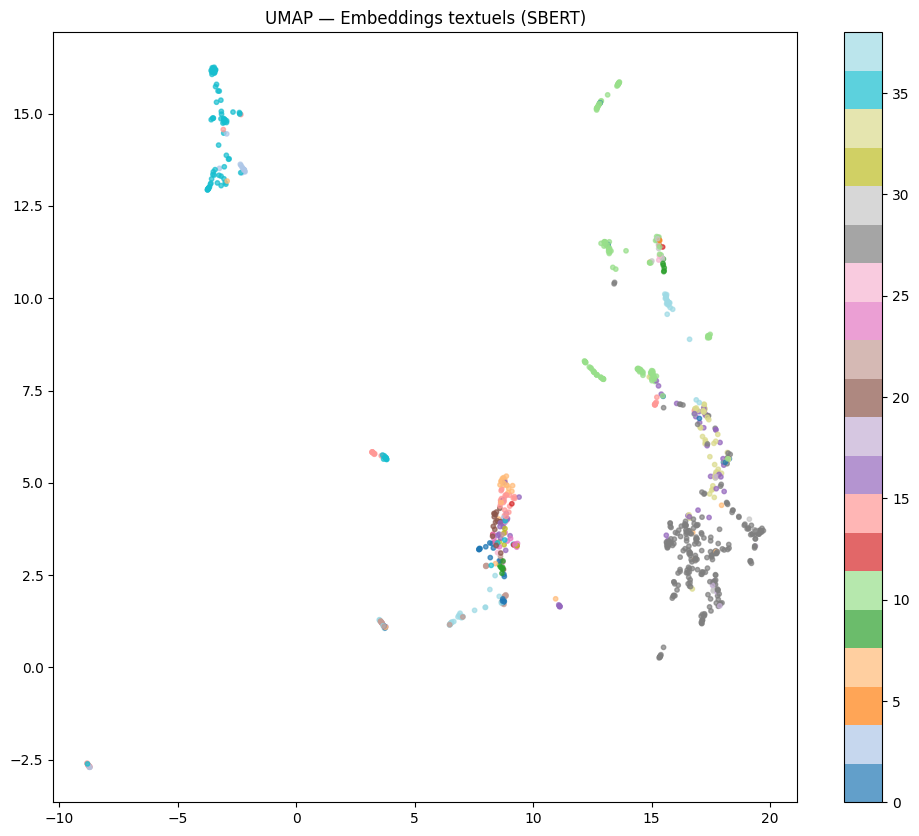

In [15]:
X_text = np.vstack(data["embedding_sbert"])

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
text_2d = reducer.fit_transform(X_text)

plt.figure(figsize=(12, 10))
plt.scatter(
    text_2d[:,0],
    text_2d[:,1],
    c=data["category2_code"].astype('category').cat.codes,
    cmap="tab20",
    s=10,
    alpha=0.7
)
plt.colorbar()
plt.title("UMAP — Embeddings textuels (SBERT)")
plt.show()


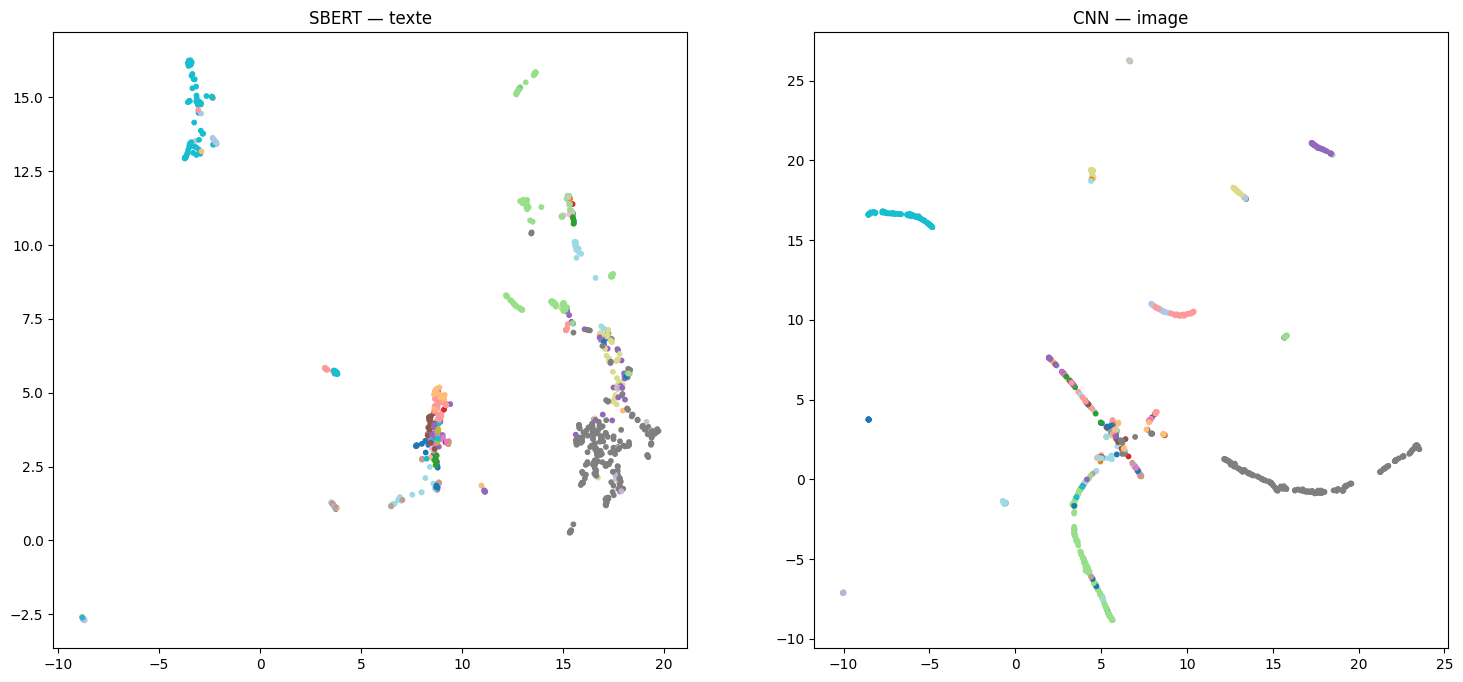

In [16]:
visu_2d = umap.UMAP(n_components=2).fit_transform(X_visu)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].scatter(text_2d[:,0], text_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[0].set_title("SBERT — texte")
ax[1].scatter(visu_2d[:,0], visu_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[1].set_title("CNN — image")
plt.show()

 Les embeddings textuels SBERT produisent des clusters modérément cohérents (ARI = 0.42). L’UMAP montre plusieurs amas compacts reflétant la structure sémantique des titres produits (“Rouge Allure”, “Sublimage”, “Eau de Parfum”), mais aussi une forte superposition due au grand nombre de titres très proches. 
 À l’inverse, les embeddings visuels issus du CNN montrent une structure beaucoup moins organisée (ARI = 0.16). Chanel utilisant une identité visuelle relativement homogène pour ses packagings, les images ne permettent pas de distinguer nettement les catégories. Les clusters reflètent davantage des ressemblances esthétiques (couleurs, textures, formes) que des regroupements fonctionnels.

 Ce qui conclut la partie 3